In [1]:
import torch
import torch.nn.functional as F

words = open("names.txt").read().splitlines()

In [2]:
from helpers import char_to_int_map, int_to_char_map

ctoi = char_to_int_map(start_char='.')
itoc = int_to_char_map(ctoi)
num_c = len(ctoi)

In [3]:
def build_dataset(words, block_size=3):
    X, Y = [], []
    for word in words:
        padded_word_list = ['.']*block_size + list(word) + ['.']
        
        for i in range(len(padded_word_list) - block_size):
            chs1 = list(map(lambda ch: ctoi[ch], padded_word_list[i:i+block_size]))
            ch2 = ctoi[padded_word_list[i+block_size]]
            X.append(chs1)
            Y.append(ch2)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [102]:
X, Y = build_dataset(words, 3) 

In [5]:
encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()

In [6]:
# layer 1
C = torch.rand((num_c, 2))

In [7]:
emb = encoder(X) @ C

/var/folders/fl/qm69qpg54kzc05jg67f46xxm0000gn/T/ipykernel_36707/265170685.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()


In [8]:
# layer 2
W1 = torch.randn((6,100))
b1 = torch.randn(100)

In [9]:
h = emb.view(-1, 6) @ W1 + b1 # set to - 1 as pytorch can infer it's dim 

In [10]:
activation = lambda layer: torch.tanh(layer)

In [11]:
layer_1_out = activation(h)

In [12]:
# decoder layer
W2 = torch.randn((100, num_c))
b2 = torch.randn(num_c)

In [13]:
logits = layer_1_out @ W2 + b2

In [14]:
logits.shape

torch.Size([228146, 27])

In [15]:
 # softmax
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)

In [16]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()

In [17]:
def MLP_tune_learning_rate(X, Y, num_c, batch_size, lre, lrs, steps=100):
    token_size = X.shape[1]
    g = torch.Generator().manual_seed(1)
    C = torch.randn((num_c, 2), generator=g)
    W1 = torch.randn((2*token_size, 100), generator=g)
    b1 = torch.randn(100, generator=g)
    W2 = torch.randn((100, num_c), generator=g)
    b2 = torch.randn(num_c, generator=g)
    
    parameters = [C, W1, b1, W2, b2]
    for p in parameters:
        p.requires_grad = True
        
    lri = []
    lossi = []
    
    for i in range(steps):
        lr = lrs[i]
        # make minibatch
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)

        # forward pass
        emb = X[ix] @ C # X here is X encoded, but since it's one hot encoded, you can also do C[X] where X is the non-encoded tensor of inputs
        l1 = emb.view((-1, token_size*C.shape[1])) @ W1 + b1 
        h = activation(l1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])
        # backwards pass
        for p in parameters:
            p.grad = None
        loss.backward()
        for p in parameters:
            p.data += -lr * p.grad
            
        lri.append(lre[i])
        lossi.append(loss.item())
        
    return loss.item(), lri, lossi
    
encx = encoder(X)
ency = encoder(Y)
batch_size = 32
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
steps = 1000
loss, lri, lossi = MLP_tune_learning_rate(encx, ency, num_c, batch_size, lre, lrs, steps)
print(loss)

/var/folders/fl/qm69qpg54kzc05jg67f46xxm0000gn/T/ipykernel_36707/265170685.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()


8.430161476135254


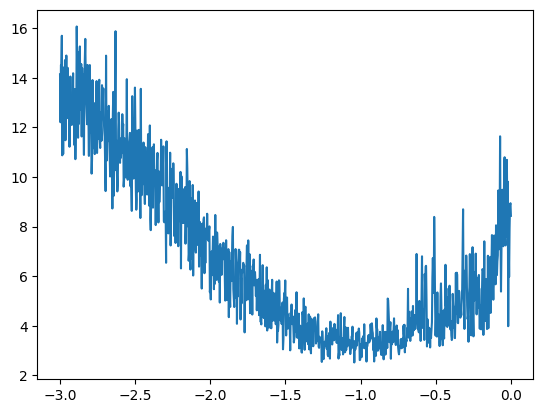

In [18]:
import matplotlib.pyplot as plt
plt.plot(lri, lossi)
# here we are plotting the exponent of the learning rate

In [81]:
def MLP(X, Y, parameters, batch_size, lr, steps=100):
    token_size = X.shape[1]
    
    C, W1, b1, W2, b2 = parameters
    
    for p in parameters:
        p.requires_grad = True
    
    for i in range(steps):
        # make minibatch
        ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)

        # forward pass
        emb = X[ix] @ C # X here is X encoded, but since it's one hot encoded, you can also do C[X] where X is the non-encoded tensor of inputs
        l1 = emb.view((-1, token_size*C.shape[1])) @ W1 + b1 
        h = activation(l1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, Y[ix])
        # backwards pass
        for p in parameters:
            p.grad = None
        loss.backward()
        for p in parameters:
            p.data += -lr * p.grad
            
        
    return loss.item()


In [82]:
encx = encoder(X)
ency = encoder(Y)
batch_size = 32
lr = 10**-1
steps = 10000
g = torch.Generator().manual_seed(1)
C = torch.randn((num_c, 2), generator=g)
W1 = torch.randn((2*X.shape[1], 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, num_c), generator=g)
b2 = torch.randn(num_c, generator=g)
parameters = [C, W1, b1, W2, b2]

loss = MLP(encx, ency, parameters, batch_size, lr, steps)
print(loss)

/var/folders/fl/qm69qpg54kzc05jg67f46xxm0000gn/T/ipykernel_36707/265170685.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()


2.3534095287323


# Now with train, val, test

In [43]:
train_size = 0.8
val_size = 0.1
test_size = 0.1
def split(data, splits):
    assert sum(splits) == 1
    data_size = len(X)
    # split_data =[ [X[:int(splits[0])]]]
    split_data = []
    # curr_sum = splits[0]
    curr_sum = 0
    for s in splits:
        split_data.append(data[int(curr_sum*data_size):int((curr_sum+s)*data_size)])
        curr_sum+=s
        
    return tuple(split_data)

In [86]:
def forward_pass(X, Y, parameters):
    C, W1, b1, W2, b2 = parameters
    
    for p in parameters:
        p.requires_grad = True
    
    emb = X @ C
    h = emb.view((-1, W1.shape[0])) @ W1 + b1
    l1 = activation(h)
    logits = l1 @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

def runMLP(encx_train, encx_val, ency_train, ency_val, num_c):
    batch_size = 32
    lr = 10**-1
    steps = 10000
    emb_layer_size = 10
    tanh_layer_size = 200
    g = torch.Generator().manual_seed(1)
    C = torch.randn((num_c, emb_layer_size), generator=g)
    W1 = torch.randn((emb_layer_size*encx_train.shape[1], tanh_layer_size), generator=g)
    b1 = torch.randn(tanh_layer_size, generator=g)
    W2 = torch.randn((tanh_layer_size, num_c), generator=g)
    b2 = torch.randn(num_c, generator=g)
    parameters = [C, W1, b1, W2, b2]
    training_loss = MLP(encx_train, ency_train, parameters, batch_size, lr, steps)
    print("training loss: ", training_loss)
    # the parameters are passed by reference, which is why they get changed and we don't have to pass them back
    val_loss = forward_pass(encx_val, ency_val, parameters)
    print("val loss: ", val_loss)
    return parameters
    
encx = encoder(X)
ency = encoder(Y)
encx_train, encx_val, encx_test  = split(encx, [0.8,0.1,0.1])
ency_train, ency_val, ency_test = split(ency, [0.8,0.1,0.1])
parameters = runMLP(encx_train, encx_val, ency_train, ency_val, num_c)

/var/folders/fl/qm69qpg54kzc05jg67f46xxm0000gn/T/ipykernel_36707/265170685.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()


training loss:  2.0817739963531494
val loss:  2.8143694400787354


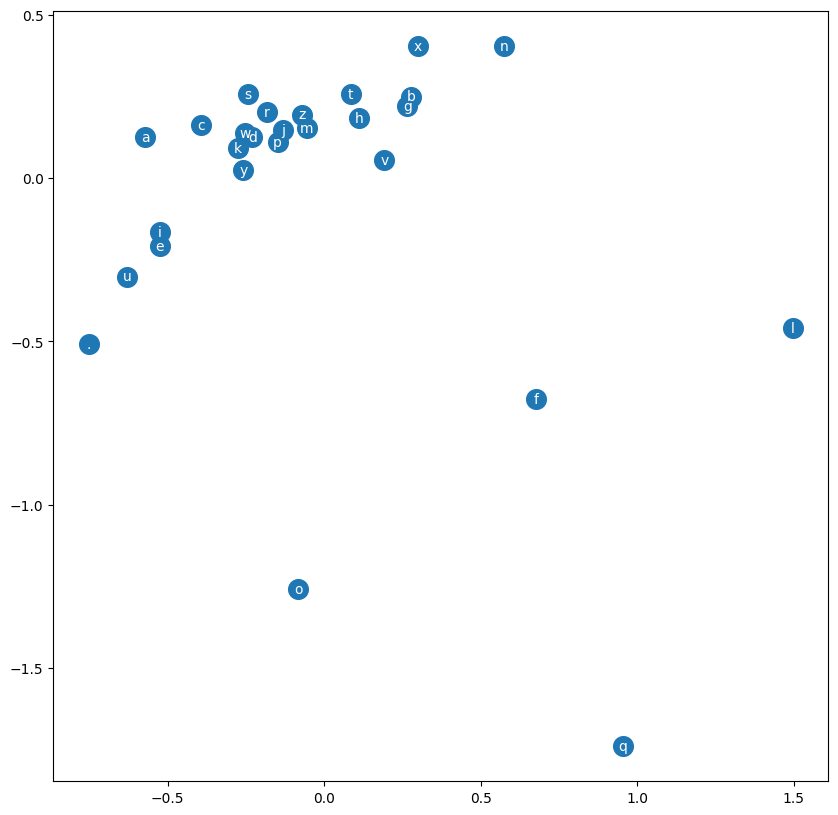

In [88]:
C = parameters[0]
plt.figure(figsize=(10,10))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i, 1].item(), itoc[i], ha="center", va="center", color="white")


In [116]:
def generator(parameters, amt):
    C, W1, b1, W2, b2 = parameters
    g = torch.Generator().manual_seed(1)
    out = []
    for i in range(amt):
        ix = [0,0,0] # our window is of length 3
        name = ''
        
        while True:
            
            enc = encoder(torch.tensor(ix))
            emb = enc @ C
            h = emb.view((-1, W1.shape[0])) @ W1 + b1
            l1 = activation(h)
            logits = l1 @ W2 + b2
            counts = logits.exp()
            probs = counts / counts.sum(dim=1, keepdim=True)
            next_char_i = torch.multinomial(probs, 1, replacement=True, generator=g)
            next_char = itoc[next_char_i.item()]
            ix.pop(0)
            ix.append(next_char_i)
            name += next_char
            if next_char_i == 0:
                break
        out.append(name)
    return out
names = generator(parameters, 10)
names

/var/folders/fl/qm69qpg54kzc05jg67f46xxm0000gn/T/ipykernel_36707/265170685.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder = lambda t: F.one_hot(torch.tensor(t), num_classes=num_c).float()


['chele.',
 'calia.',
 'flon.',
 'jarirss.',
 'malee.',
 'safi.',
 'ricestlei.',
 'roat.',
 'cadleighe.',
 'azya.']